# Exercise 1: Maximum-likelihood fitting

In this exercise we will implement a maximum-likelihood fit using the common example of fitting a Gaussian curve to some normally-distributed data.

The main task will be to implement a gradient-descent algorithm.


## Parameters

The objective of fitting a PDF to data is to find the values of the PDF's parameters that maximise the likelihood, thus giving the best description of a dataset (i.e. the best fit).

While it's possible to store parameters as simple `float`s, we ask that you implement a class that stores the parameter value and a range that the value cannot stray outside during the fit. This will be especially helpful while testing and debugging your minimiser

## PDFs and likelihoods

A Gaussian PDF is defined as:
$$
f(x|\mu,\sigma) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

The likelihood is the product of the PDF evaluated on all points $\{x_i\}$ in a dataset (assuming all points are independent):

$$
\mathcal{L}(\mu,\sigma) = \prod_i f(x_i|\mu,\sigma)
$$

Rather than maximise the likelihood, it is easier computationally to minimise the negative log-likelihood:
$$
-\log(\mathcal{L}(\mu,\sigma)) = -\sum_i\log(f(x_i|\mu,\sigma))
$$

## Minimisation via gradient descent

Gradient descent is a method of finding the local minimum of a differentiable function by following the local gradient.

Note that the local minimum may not be the same as the global minimum. There are strategies to avoid a local-but-not-global minimum, such as performing a fit multiple times with random starting values.

Say we have a multivariate function $L(\vec{\theta})$, where $\vec{\theta} = [\theta_1, \theta_2, ..., \theta_n].$ _**NB**: in this exercise, $L(\vec{\theta})=-\log(\mathcal{L}(\mu,\sigma))$, the negative log-likelihood._

The gradient of the function is $$\nabla_\theta L(\vec{\theta}) = \left[\frac{\partial L}{\partial \theta_1}, \frac{\partial L}{\partial \theta_2}, ..., \frac{\partial L}{\partial \theta_n}\right].$$

Starting from some initial position $\vec{\theta}_i$, one can descend the gradient towards the minimum by subtracting an amount proportional to the local gradient: $$\vec{\theta}_{t} = \vec{\theta}_{t-1} - \eta_t \nabla_\theta L(\vec{\theta}_{t-1}),$$ where $\eta_t$ is the "step size". This can be repeated until $\vec{\theta}$ converges on the values that minimise $L(\vec{\theta})$ (i.e. the best-fit values $\vec{\hat{\theta}}$).

The exact criterion for achieving convergence is up to you to decide and implement.
A good starting point is to use the relative change $$\left|\frac{L(\vec{\theta}_{i})-L(\vec{\theta}_{i-1})}{L(\vec{\theta}_{i})+L(\vec{\theta}_{i-1})}\right|$$ and stop when it goes below some threshold.

Choosing an appropriate step size $\eta_t$ is crucial for an optimal balance between speed and precision, and many methods are available for doing this. Note that it does not need to be a fixed size and can be adjusted at each iteration.

### Batch vs stochastic

In batch gradient descent, the parameters are updated using the likelihood calculated over the full dataset.

In stochastic gradient descent, the parameters are updated for each datapoint (using $\nabla_\theta L(\vec{\theta}, x_i)$), or a sub-sample of the full dataset (mini-batch).

*See the lecture notes for more.*

### Momentum

Useful particularly in stochastic/mini-batch gradient descent is the idea of 'momentum'. Where the parameters are updated using: $$\vec{\theta}_t = \vec{\theta}_{t-1} - \vec{v}_t,$$ where $$\vec{v}_t = \gamma \vec{v}_{t-1} + \eta_t \nabla_\theta L(\vec{\theta}_{t-1}, x),$$ where $\gamma$ is the momentum parameter $0 < \gamma < 1$ (typically around 0.9).

### Nesterov's accelerated gradient descent

Using momentum we can 'look ahead' to where the next update will be approximately, without calculating a new gradient: $$\vec{\theta}_t \approx \vec{\theta}_{t-1} - \gamma \vec{v}_{t-1}$$

We can instead use that position when calculating the new gradient, so $\vec{v}_t$ becomes: $$\vec{v}_t = \gamma \vec{v}_{t-1} + \eta_t \nabla_\theta L(\vec{\theta}_{t-1} - \gamma \vec{v}_{t-1}, x).$$

## Implementing your own gradient-descent minimiser

Here you should implement:
1. A parameter class that holds the value and allowed range of a parameter
  - When setting a value outside the allowed range, force the value to equal the nearest boundary
2. A Gaussian PDF class or function using parameters that control its mean and standard deviation
3. A gradient-descent minimiser which iteratively:
  - Calcualtes the likelihood gradient at the current values of the fit parameters
  - Updates the parameters following the gradient
  - Saves the likelihood in a list (for plotting later)
  - Stops the fit if it has converged (or if a maximum number of iterations have been reached)

Sigma:  30
Mu:     5299.625613012774


/var/folders/c5/qgm3_x4n23b9qxk0ff5f1_fh0000gn/T/ipykernel_69421/2844813018.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  grad = (y_array[0]-y_array[1])/h


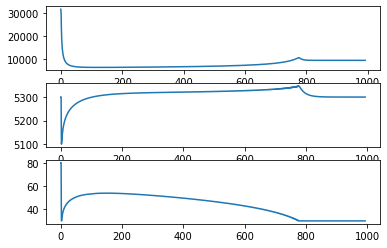

In [34]:
# Implement the parameter class, the Guassian PDF and gradient-descent minimisation here
# You can create extra cells if you wish
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# test_array_x = np.array([0,1,4,5,2,10])
# text_array_y = np.array([-1,0,2,3,4,8])

def sign():
    a=np.random.uniform(low=0.0, high=1.0, size=None)
    if a<0.5:
        return 1
    else:
        return -1

df = pd.read_csv("test_data.csv", names=["mass"])

upper_limit_mu = 5500
lower_limit_mu = 5100
upper_limit_sigma = 200
lower_limit_sigma = 30

class parameter:                                                                 # define a simple parameter class
    def __init__(self, value, lower_bound, upper_bound):
        self.range = [lower_bound,upper_bound]
        self.low = lower_bound
        self.up = upper_bound
        if value < lower_bound:
            self.value = lower_bound
        elif value > upper_bound:
            self.value = upper_bound
        else:
            self.value = value
            
class gaus:                                                                      # define a simple gaus class
    def __init__(self, x, sigma, mu):
        self.x = x
        self.sigma = sigma
        self.mu = mu
    def value(self):
        return 1/(self.sigma * np.sqrt(2 * np.pi)) * np.exp(-(self.x-self.mu)**2/(2 * self.sigma ** 2))
    def log(self):
        return np.log(self.value())

class GD_minimiser:
    def __init__(self, stepsize, max_iteration, sigma, mu):
        self.nllh = [1]
        self.mu = [parameter(mu, lower_limit_mu-stepsize, upper_limit_mu+stepsize).value]
        self.sigma = [parameter(sigma, lower_limit_sigma-stepsize, upper_limit_sigma+stepsize).value]
        self.iteration = 1
        self.stepsize = stepsize
        self.max_iteration = max_iteration
       
    def run_GD(self, x, gaus):
        # print(self.nllh, self.sigma, self.mu[-1])
        self.sigma.append( parameter( self.sigma[-1] + self.stepsize , lower_limit_sigma , upper_limit_sigma ).value)
        self.mu.append(parameter(self.mu[-1]+self.stepsize,lower_limit_mu, upper_limit_mu).value)
        self.nllh.append(-np.sum(gaus(x, self.sigma[-1], self.mu[-1]).log()))        # First iteration to get two values to start GD
        # print(self.nllh)
        # print("Starting accuracy:", (self.nllh[-2]-self.nllh[-1])/(self.nllh[-2]+self.nllh[-1]))
        while (np.abs((self.nllh[-2]-self.nllh[-1])/(self.nllh[-2]+self.nllh[-1])) > 1e-12): # stop condition abritrarily chosen
            # if (self.iteration%3==0):
            
            self.sigma.append( parameter( self.sigma[-1]-self.stepsize * array_grad(np.array(self.nllh[-2:]), np.array(self.sigma[-2:])), \
                                         lower_limit_sigma, upper_limit_sigma).value) # calculate sigma from value before
            # else:
            
            self.mu.append(parameter(self.mu[-1]-self.stepsize*90*array_grad(np.array(self.nllh[-2:]),np.array(self.mu[-2:])),lower_limit_mu,upper_limit_mu).value) # caluclate mu from value before
            # self.mu.append(5300)
            
            self.nllh.append(-np.sum(gaus(x, self.sigma[-1], self.mu[-1]).log()))     # calculate new nllh
            self.iteration = self.iteration+1                                         # count up
            if self.iteration > self.max_iteration:                                   # check wheather max iterations is reached 
                print("Maximum allowed amout of iterations reached:", self.max_iteration)
                print("Final Accuracy: ", np.abs((self.nllh[-2]-self.nllh[-1])/(self.nllh[-2]+self.nllh[-1])))
                break                                                                 # and if so, break the loop
                
            # if self.nllh[-2]<self.nllh[-1]:                                           # shoud not be needed
            #     if self.iteration>8:                                                  # does no longer happen if I try
            #         print("Found a local mimimum")                                    # but without it the code does not work
            #         break                                                             # for some strange reason
    def run_GD_batch(self, x, gaus, number_of_mimi_batches):
            # Split up x:
            
            mini_b = np.reshape(x, (number_of_mimi_batches, len(x)/number_of_mimi_batches))
            for i in range(number_of_mimi_batches):
                self.run_GD(mini_b[i], gaus)

# def array_grad(y_array, x_array = [0]):
#     if len(x_array) < 2 :
#         x_array = np.linspace(1,len(y_array),len(y_array))
#         print("No x_array defined!")
#     if len(y_array) < 2 :
#         print("Invalid input! Need array with 2 or more elements!")
#         return [0]
#     h = (x_array[1:] - x_array[:-1])
#     if h == 0:
#          h = sign()*.02
#          print("division by zero! Setting stepsize to be ", h)
#     # print(len(y_array),x_array)
#     one = (y_array[-1] - y_array[-2])/h
#     return float(one)
    
def array_grad(y_array, x_array):
    h = (x_array[0]-x_array[1])
    grad = (y_array[0]-y_array[1])/h
    if grad == 0 :
        grad = np.random.uniform(low=1., high=10.0)
    return grad

max_steps = 5*1e4                                                               # maximally allowed steps
steps = 5*1e-4                                                                  # step size

test = GD_minimiser(steps,max_steps, 80, 5300)                                 # initialize GD

x = df["mass"]
test.run_GD(x, gaus)                                                            # run GD
print("Sigma: ",test.sigma[-1])
print("Mu:    ",test.mu[-1])

fig, (ax1,ax2,ax3) = plt.subplots(3)
ax1.plot(np.arange(0,len(test.nllh[2:])), test.nllh[2:])
ax2.plot(np.arange(0,len(test.mu)),test.mu)
ax3.plot(np.arange(0,len(test.sigma)),test.sigma)
plt.show()



# print(np.finfo(float).eps)                                                    # find out the epsilon of floats

## Fitting data

The data sample provided with this sheet consists of Gaussian-distributed measurements of the $B^0$ meson mass, in units of MeV. The standard deviation of the distribution is dominated by the resolution of the detector used to make the measurement.

Your task is to obtain best-fit values for the mass of the meson (i.e. the mean, $\mu$) and the detector resolution (i.e. the standard deviation $\sigma$) using your minimiser and Gaussian PDFs implemented above.

In the cell below, the data is loaded into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and plotted as a [Matplotlib histogram](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html). This should give you an idea of which starting values and ranges to set for the parameters.

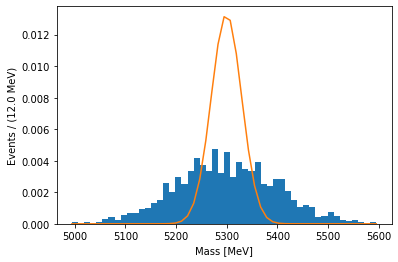

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("test_data.csv", names=["mass"])

num_bins = 50
_, bins, _ = plt.hist(df["mass"], num_bins, density=True)
# print(bins)

bin_width = (bins[-1] - bins[0])/num_bins
plt.xlabel("Mass [MeV]")
plt.ylabel(f"Events / ({bin_width:.1f} MeV)")
plt.plot(bins, gaus(bins,test.sigma[-1],test.mu[-1]).value())
plt.show()

[4994.60945746 4995.21434218 4995.81922689 4996.42411161 4997.02899633
 4997.63388104 4998.23876576 4998.84365048 4999.44853519 5000.05341991
 5000.65830463 5001.26318935 5001.86807406 5002.47295878 5003.0778435
 5003.68272821 5004.28761293 5004.89249765 5005.49738236 5006.10226708
 5006.7071518  5007.31203651 5007.91692123 5008.52180595 5009.12669067
 5009.73157538 5010.3364601  5010.94134482 5011.54622953 5012.15111425
 5012.75599897 5013.36088368 5013.9657684  5014.57065312 5015.17553783
 5015.78042255 5016.38530727 5016.99019199 5017.5950767  5018.19996142
 5018.80484614 5019.40973085 5020.01461557 5020.61950029 5021.224385
 5021.82926972 5022.43415444 5023.03903915 5023.64392387 5024.24880859
 5024.85369331 5025.45857802 5026.06346274 5026.66834746 5027.27323217
 5027.87811689 5028.48300161 5029.08788632 5029.69277104 5030.29765576
 5030.90254047 5031.50742519 5032.11230991 5032.71719463 5033.32207934
 5033.92696406 5034.53184878 5035.13673349 5035.74161821 5036.34650293
 5036.951

ValueError: x and y must have same first dimension, but have shapes (994,) and (1,)

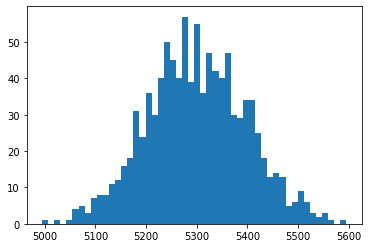

In [3]:
# Use this cell to perform a fit to the data
print(np.linspace(bins[0], bins[-1], len(test.nllh)))
print(gaus(np.linspace(bins[0], bins[-1], len(test.nllh[:])),test.sigma[-1], test.mu[-1]).value)
# print(test.nllh[:])
num_bins = 50
_, bins, _ = plt.hist(df["mass"], num_bins)
bin_width = (bins[-1] - bins[0])/num_bins
plt.plot(np.linspace(bins[0], bins[-1], len(test.nllh)), gaus(np.linspace(bins[0], bins[-1], len(test.nllh)),test.sigma[-1], test.mu[-1]).value)
plt.xlabel("Mass [MeV]")
plt.ylabel(f"Events / ({bin_width:.1f} MeV)")
plt.show()

## Plotting the results

1. Plot the PDF with best-fit values overlaid on to a histogram of the data.
  - _**Hint**: to achieve the same normalisation for the data and the PDF, you may choose to use `density=True` in the arguments to `pyplot.hist`_
1. Plot a 'likelihood trace' (i.e. the 'history' of the likelihood at each iteration) for the following cases:
  - Several choices of fixed step size for batch gradient descent
  - The effect of different methods of gradient-descent (6 in total)
    - batch
    - mini-batch
    - stochastic
    - all of the above using the Nesterov technique

In [ ]:
e = 1e2
n = 1
while e+1 > 1:
    e = np.prod(np.arange(1, n, dtype=np.double))
    print(n, e)
    n += 1

np.arange(1, 21).prod()